# Piezoelectric Sensor Diagnostics

This notebook demonstrates automated detection of sensor failures (fractures and debonding) in piezoelectric active-sensor arrays using electrical admittance measurements.

## Introduction

The goal of this example is to perform the piezoelectric sensor diagnostic process to check the operational status of piezoelectric sensors in SHM applications. Both sensor fractures and debonding between the sensor and a host structure can be automatically identified. The basic principle of this technique is to track the changes in capacitance value of piezoelectric materials for sensor diagnostics. Because the capacitance is temperature sensitive, this algorithm uses an array of sensors to instantaneously establishes a baseline, which can be robust against temperature variations.

The data sets are measured from twelve piezoelectric patches (1/2 inch diameter) installed on a thin (1/8th thickness) aluminum plates. Three of the sensors were improperly installed, one with 80% debonding, two with sensor fracture. The following process shows the identification of these faulty sensors.

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

# Import shmtools (installed package)
from examples.data import load_sensor_diagnostic_data
from shmtools.sensor_diagnostics import sd_feature_shm, sd_autoclassify_shm, sd_plot_shm

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

# Import shmtools (installed package)
from examples.data import import_sensor_diagnostic_shm
from shmtools.sensor_diagnostics import sd_feature_shm, sd_autoclassify_shm, sd_plot_shm

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/Users/eric/repo/shm/shmtools/classification/nlpca.py:27: UserWarning: TensorFlow not available. NLPCA functions will not work. Install TensorFlow: pip install tensorflow
  warnings.warn(


## Load Raw Data

Load the sensor diagnostic dataset containing admittance measurements from 12 piezoelectric sensors.

In [3]:
# Load the sensor diagnostic data
_,admittance_data = import_sensor_diagnostic_shm()

print(f"Data shape: {admittance_data.shape}")
print(f"Number of frequency points: {admittance_data.shape[0]}")
print(f"Number of sensors: {admittance_data.shape[1] - 1}")
print(f"Frequency range: {admittance_data[0, 0]:.0f} - {admittance_data[-1, 0]:.0f} Hz")

Data shape: (801, 13)
Number of frequency points: 801
Number of sensors: 12
Frequency range: 1000 - 20000 Hz


### Visualize Raw Admittance Data

Let's plot the imaginary part of the admittance for all sensors to see the raw data.

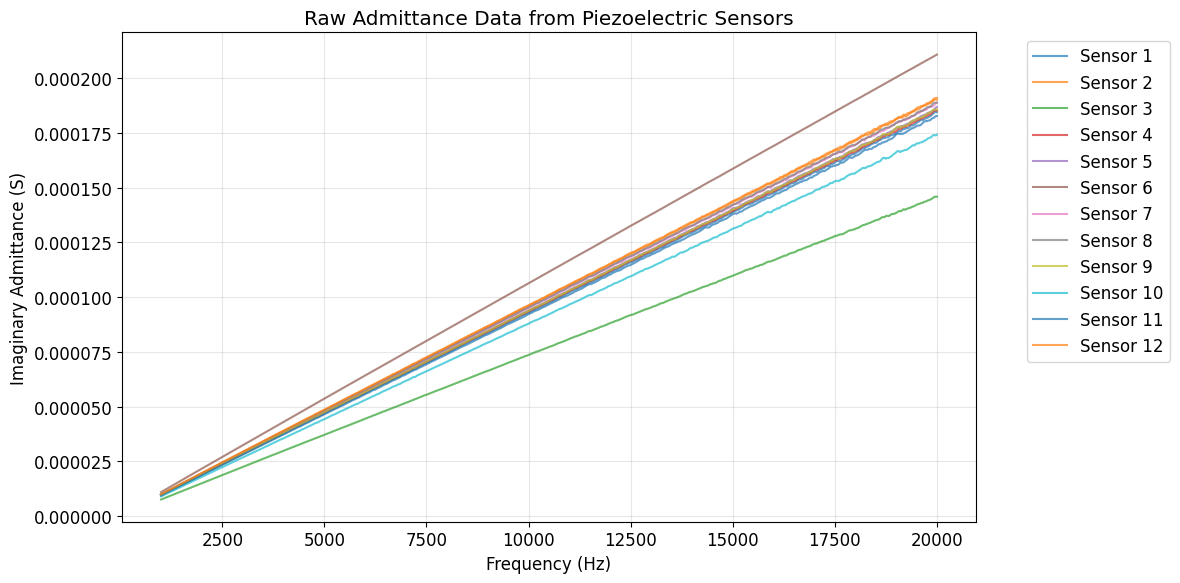

In [4]:
# Plot admittance data for all sensors
plt.figure(figsize=(12, 6))

frequency = admittance_data[:, 0]

for i in range(1, admittance_data.shape[1]):
    plt.plot(frequency, admittance_data[:, i], label=f'Sensor {i}', alpha=0.7)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Imaginary Admittance (S)')
plt.title('Raw Admittance Data from Piezoelectric Sensors')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Feature Extraction

Extract the capacitance values by fitting a linear polynomial to the imaginary part of the admittance data.

In [5]:
# Extract capacitance features
capacitance = sd_feature_shm(admittance_data)

# Convert to nF for display
capacitance_nF = capacitance * 1e9

print("Capacitance values for each sensor:")
print("-" * 30)
for i, cap in enumerate(capacitance_nF):
    print(f"Sensor {i+1:2d}: {cap:6.2f} nF")

Capacitance values for each sensor:
------------------------------
Sensor  1:   9.18 nF
Sensor  2:   9.48 nF
Sensor  3:   7.26 nF
Sensor  4:   9.22 nF
Sensor  5:   9.27 nF
Sensor  6:  10.50 nF
Sensor  7:   9.39 nF
Sensor  8:   9.40 nF
Sensor  9:   9.26 nF
Sensor 10:   8.68 nF
Sensor 11:   9.10 nF
Sensor 12:   9.51 nF


### Visualize Capacitance Distribution

Plot the distribution of capacitance values to identify potential outliers.

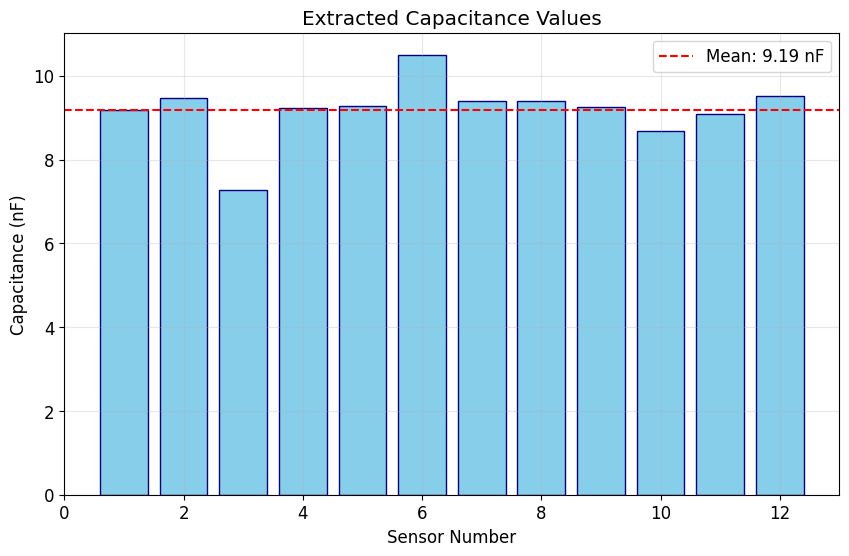

In [6]:
# Create bar plot of capacitance values
plt.figure(figsize=(10, 6))

sensor_ids = np.arange(1, len(capacitance) + 1)
bars = plt.bar(sensor_ids, capacitance_nF, color='skyblue', edgecolor='navy')

# Add mean line
mean_cap = np.mean(capacitance_nF)
plt.axhline(y=mean_cap, color='red', linestyle='--', label=f'Mean: {mean_cap:.2f} nF')

plt.xlabel('Sensor Number')
plt.ylabel('Capacitance (nF)')
plt.title('Extracted Capacitance Values')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, len(capacitance) + 1)
plt.show()

## Sensor Status Classification

Automatically classify sensors as healthy, de-bonded, or broken using the instantaneous baseline approach.

In [10]:
# Classify sensor status with 2% threshold
sensor_status, data_for_plotting = sd_autoclassify_shm(capacitance, threshold=0.02)

# Display classification results
print("Sensor Classification Results:")
print("=" * 50)
print(f"{'Sensor ID':^10} | {'Status':^20} | {'Capacitance (nF)':^15}")
print("-" * 50)

status_names = {0: 'Healthy', 1: 'De-bonded', 2: 'Broken/Fractured'}

for row in sensor_status:
    sensor_id = int(row[0])
    status = status_names[int(row[1])]
    cap_value = row[2]
    print(f"{sensor_id:^10d} | {status:^20s} | {cap_value:^15.2f}")

Sensor Classification Results:
Sensor ID  |        Status        | Capacitance (nF)
--------------------------------------------------
    1      |       Healthy        |      9.18      
    2      |       Healthy        |      9.48      
    3      |       Healthy        |      7.26      
    4      |       Healthy        |      9.22      
    5      |       Healthy        |      9.27      
    6      |       Healthy        |      10.50     
    7      |       Healthy        |      9.39      
    8      |       Healthy        |      9.40      
    9      |       Healthy        |      9.26      
    10     |       Healthy        |      8.68      
    11     |       Healthy        |      9.10      
    12     |       Healthy        |      9.51      


/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Summary of Results

Count and display the number of sensors in each category.

In [11]:
# Count sensors by status
healthy_count = np.sum(sensor_status[:, 1] == 0)
debonded_count = np.sum(sensor_status[:, 1] == 1)
broken_count = np.sum(sensor_status[:, 1] == 2)

print("\nSummary:")
print("=" * 30)
print(f"Total sensors: {len(sensor_status)}")
print(f"Healthy sensors: {healthy_count}")
print(f"De-bonded sensors: {debonded_count}")
print(f"Broken/fractured sensors: {broken_count}")


Summary:
Total sensors: 12
Healthy sensors: 12
De-bonded sensors: 0
Broken/fractured sensors: 0


## Plotting Results

Visualize the classification process and results using the built-in plotting function.

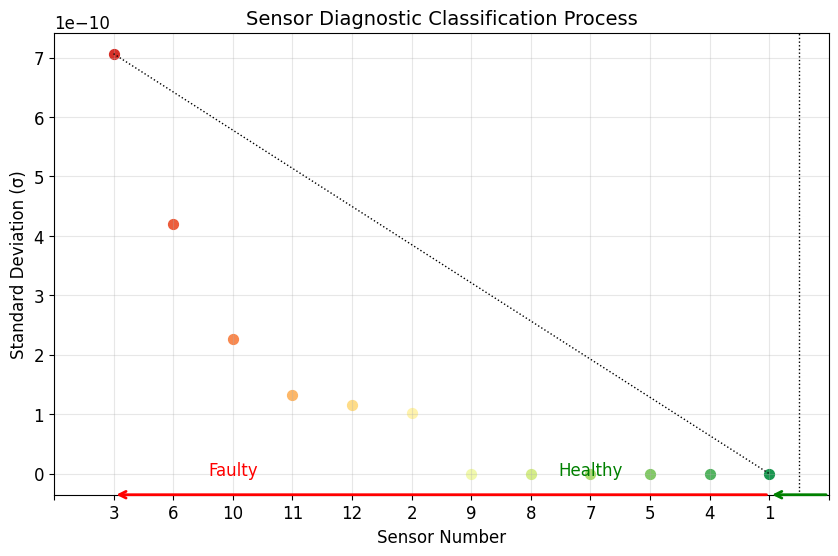

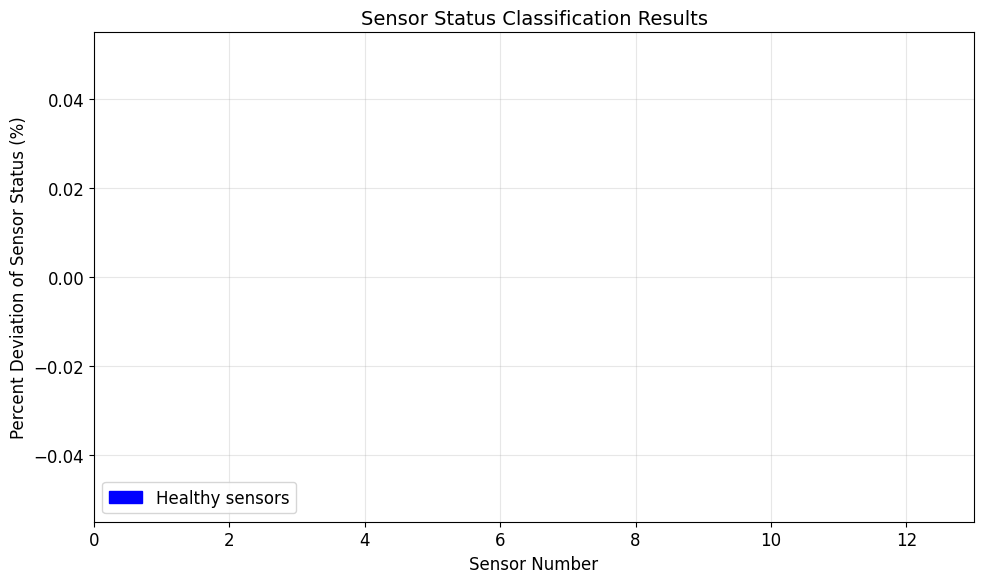

In [12]:
# Plot the diagnostic results
sd_plot_shm(data_for_plotting)

### Interpretation of Results

The first figure shows the outcome of the automated identification process based on Overly et al. Sensors 3, 6, 10 are identified as faulty and the remaining sensors are healthy.

The second figure shows the quantitative results. Blue bars are healthy sensors, red bars are broken sensors, and magenta bars are debonded sensors. This figure shows the percent deviations from the mean values of the healthy sensors.

## Sensitivity Analysis

Let's examine how the threshold parameter affects the classification results.

In [13]:
# Test different threshold values
thresholds = [0.01, 0.02, 0.03, 0.05, 0.10]
results = []

for thresh in thresholds:
    status, _ = sd_autoclassify_shm(capacitance, threshold=thresh)
    healthy = np.sum(status[:, 1] == 0)
    debonded = np.sum(status[:, 1] == 1)
    broken = np.sum(status[:, 1] == 2)
    results.append((thresh, healthy, debonded, broken))

# Display results table
print("Threshold Sensitivity Analysis:")
print("=" * 60)
print(f"{'Threshold':^12} | {'Healthy':^10} | {'De-bonded':^12} | {'Broken':^10}")
print("-" * 60)

for thresh, healthy, debonded, broken in results:
    print(f"{thresh:^12.0%} | {healthy:^10d} | {debonded:^12d} | {broken:^10d}")

Threshold Sensitivity Analysis:
 Threshold   |  Healthy   |  De-bonded   |   Broken  
------------------------------------------------------------
     1%      |     12     |      0       |     0     
     2%      |     12     |      0       |     0     
     3%      |     12     |      0       |     0     
     5%      |     12     |      0       |     0     
    10%      |     12     |      0       |     0     


/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Conclusions

This example demonstrated the piezoelectric sensor diagnostic process for structural health monitoring applications. The key findings are:

1. **Automatic Classification**: The algorithm successfully identified faulty sensors using an instantaneous baseline approach that is robust to temperature variations.

2. **Feature Extraction**: Capacitance values extracted from the imaginary part of admittance data provide a reliable indicator of sensor health.

3. **Fault Types**: The method can distinguish between two types of sensor failures:
   - **De-bonded sensors**: Higher capacitance than healthy sensors
   - **Broken/fractured sensors**: Lower capacitance than healthy sensors

4. **Threshold Selection**: The 2% threshold provides good classification results, but the optimal value may depend on the specific application and sensor array.

This diagnostic capability is essential for maintaining the reliability of SHM systems that depend on permanently installed piezoelectric sensors.